# Predicting Taxi Fare

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [2]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.dropna(inplace=True)


pickup_dt = df.pickup_datetime.dt
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', inplace=True)

df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Dataset Splitting

In [3]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

# Training

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [6]:
rsp.enet_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [7]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ["passenger_count", 'year', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'), ["month", 'day', 'hour']),
])

from sklearn.linear_model import ElasticNet
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished
C:\Users\ASUS\miniconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:2970: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.00012575549573395252, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8095010461397156, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7195136116796721 0.7160608685633232 0.7467155093396689


C:\Users\ASUS\miniconda3\envs\jcopml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177372.87394031713, tolerance: 140.34017623508709
  positive)


# Feature Importance

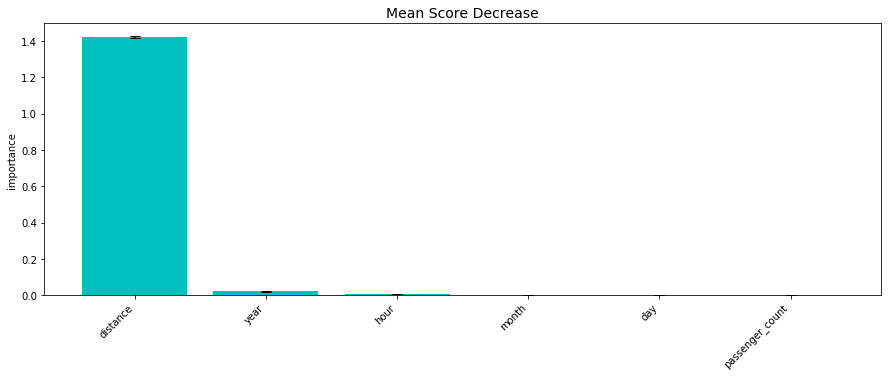

In [9]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

# Evaluation

In [10]:
from jcopml.plot import plot_residual

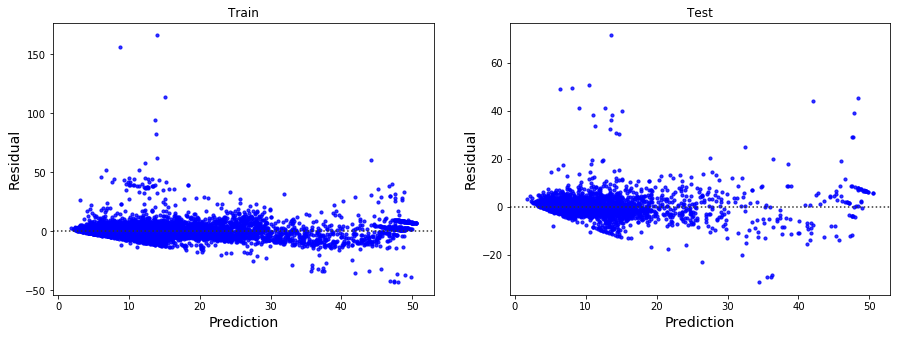

In [11]:
plot_residual(X_train, y_train, X_test, y_test, model)

### Masih terdapat unbalanced, mari kita cek data

In [12]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred- y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values('error', ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.122791
1483,1.0,2009,8,4,21,0.000416,165.00,156.266630
6630,1.0,2014,5,4,1,0.000000,128.83,113.742022
14142,1.0,2014,12,4,10,0.045860,108.00,94.340081
12915,1.0,2011,9,2,1,0.000000,96.00,82.253870
10524,1.0,2010,5,1,14,0.000000,75.80,61.827739
12349,1.0,2010,5,5,15,0.434492,104.67,60.468320
1494,1.0,2009,9,1,14,0.000031,70.00,57.763328
2432,1.0,2012,11,4,1,0.003817,58.60,51.856604
2346,1.0,2009,2,5,0,0.000000,63.00,51.602726


In [13]:
df[df.fare_amount <= 0]

,fare_amount,passenger_count,year,month,day,hour,distance
2039,-2.9,1.0,2010,3,1,23,0.002331
2486,-2.5,1.0,2015,3,6,5,0.000313
10002,0.0,1.0,2010,2,0,14,0.043644
13032,-3.0,4.0,2013,8,4,8,0.001425


In [15]:
from jcopml.plot import plot_correlation_matrix

In [29]:
plot_correlation_matrix(df, 'fare_amount', numeric_col=['passenger_count', 'year', 'distance'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…